In [1]:
# Standard Imports

import numpy as np
import pandas as pd
import os
import sys
from collections import defaultdict
from importlib import reload
from bs4 import BeautifulSoup
import requests

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# Load MongoDB

from pymongo import MongoClient
client = MongoClient()
# Access/Initiate Database
db = client['producer_db']
# Access/Initiate Table
tab = db['songs']
collection = db.tab

# Authorize Spotify API

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

client_id = os.environ['SPOTIFY_CLIENT_ID']
client_secret = os.environ['SPOTIFY_CLIENT_SECRET']
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [2]:
len(collection.find_one()['audio_analysis']['segments'])

498

### Gameplan: 

Make a `timbre` array for every song of size (12,100) by taking the first 100 segments. Make a dictionary where...

In [3]:
test_dict = {'colA':[1,2,3],
             'colB':[4,5,6],
             'colC':['now','we are','done'],
             'colD':[np.array([1,2,3]),np.array([1,2,3]),np.array([1,2,3])]}

pd.DataFrame(test_dict)['colD'][0]

array([1, 2, 3])

In [4]:
track = collection.find_one()['track']
artist = collection.find_one()['artist']
producer = collection.find_one()['producer']

In [5]:
timbre_list = []

for i in range(100):
    timbre_list.append(collection.find_one()['audio_analysis']['segments'][i]['timbre'])
    
timbre = np.stack(timbre_list)

In [6]:
timbre.flatten().shape

(1200,)

Let's see if we can use PCA to distinguish between George Martin (ct. 130) and Rick Rubin (ct. 155)

In [7]:
gm = collection.find({'producer':'George Martin'})
rr = collection.find({'producer':'Rick Rubin'})

In [8]:
tracks = []
artists = []
producers = []
timbres = []
collections = [gm, rr]

for collection in collections:
    for song in collection:
        track = song['track']
        artist = song['artist']
        producer = song['producer']

        timbre_list=[]
        for i in range(80):
            timbre_list.append(song['audio_analysis']['segments'][i]['timbre'])
        timbre = np.concatenate(timbre_list, axis=0)
    
        tracks.append(track)
        artists.append(artist)
        producers.append(producer)
        timbres.append(timbre)
        
producer_dict = {}
producer_dict['track'] = tracks
producer_dict['artist'] = artists
producer_dict['producer'] = producers
producer_dict['timbre'] = timbres

producer_df = pd.DataFrame(producer_dict)

producer_df.head()

,track,artist,producer,timbre
0,12-Bar Original,the Beatles,George Martin,"[0.0, 171.13, 9.469, -28.48, 57.491, -50.067, ..."
1,Across the Universe,the Beatles,George Martin,"[0.0, 171.13, 9.469, -28.48, 57.491, -50.067, ..."
2,Act Naturally,Buck Owens and the Buckaroos,George Martin,"[41.561, 196.927, 110.997, 28.169, 47.868, -31..."
3,Alfie,Cilla Black,George Martin,"[0.0, 171.13, 9.469, -28.48, 57.491, -50.067, ..."
4,All I've Got to Do,the Beatles,George Martin,"[0.0, 171.13, 9.469, -28.48, 57.491, -50.067, ..."


In [9]:
producer_df.producer.value_counts()

George Martin    213
Rick Rubin       155
Name: producer, dtype: int64

In [12]:
producer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 4 columns):
track       368 non-null object
artist      368 non-null object
producer    368 non-null object
timbre      368 non-null object
dtypes: object(4)
memory usage: 11.6+ KB


In [16]:
# Class balance a df. 155 Rick Rubin and 155 George Martin

df = producer_df[producer_df['producer'] == "George Martin"].sample(155, random_state = 137)
df2 = producer_df[producer_df['producer'] == "Rick Rubin"]

In [24]:
data = pd.concat([df, df2], axis = 0)
data['target'] = (data['producer'] == 'George Martin').astype(int)

In [25]:
data.head(), data.tail()

(                                    track       artist       producer  \
 125                              No Reply  the Beatles  George Martin   
 126  Norwegian Wood (This Bird Has Flown)  the Beatles  George Martin   
 173                                Taxman  the Beatles  George Martin   
 174                  Tell Me What You See  the Beatles  George Martin   
 102                             Let It Be  the Beatles  George Martin   
 
                                                 timbre  target  
 125  [0.0, 171.13, 9.469, -28.48, 57.491, -50.067, ...       1  
 126  [0.0, 171.13, 9.469, -28.48, 57.491, -50.067, ...       1  
 173  [0.0, 171.13, 9.469, -28.48, 57.491, -50.067, ...       1  
 174  [0.0, 171.13, 9.469, -28.48, 57.491, -50.067, ...       1  
 102  [27.339, -115.081, -4.784, 13.866, 53.215, 100...       1  ,
                                             track                 artist  \
 363                   You Don't Know How It Feels              Tom Petty   
 36

In [45]:
# Set up a test train split. 

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [40]:
X = np.stack(data['timbre'].to_list())
y = data['target'].values

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 137, test_size = 0.3 )

In [42]:
X_train.shape, X_test.shape

((217, 960), (93, 960))

In [75]:
ss = StandardScaler()
X_train_centered = ss.fit_transform(X_train)
pca = PCA(n_components=12)
X_pca = pca.fit_transform(X_train_centered)

In [76]:
def scree_plot(ax, pca, n_components_to_plot=8, title=None):
    """Make a scree plot showing the variance explained (i.e. varaince of the projections) for the principal components in a fit sklearn PCA object.
    
    Parameters
    ----------
    ax: matplotlib.axis object
      The axis to make the scree plot on.
      
    pca: sklearn.decomposition.PCA object.
      A fit PCA object.
      
    n_components_to_plot: int
      The number of principal components to display in the skree plot.
      
    title: str
      A title for the skree plot.
    """
    num_components = pca.n_components_
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    ax.plot(ind, vals, color='blue')
    ax.scatter(ind, vals, color='blue', s=50)

    for i in range(num_components):
        ax.annotate(r"{:2.2f}%".format(vals[i]), 
                   (ind[i]+0.2, vals[i]+0.005), 
                   va="bottom", 
                   ha="center", 
                   fontsize=12)

    ax.set_xticklabels(ind, fontsize=12)
    ax.set_ylim(0, max(vals) + 0.05)
    ax.set_xlim(0 - 0.45, n_components_to_plot + 0.45)
    ax.set_xlabel("Principal Component", fontsize=12)
    ax.set_ylabel("Variance Explained (%)", fontsize=12)
    if title is not None:
        ax.set_title(title, fontsize=16)

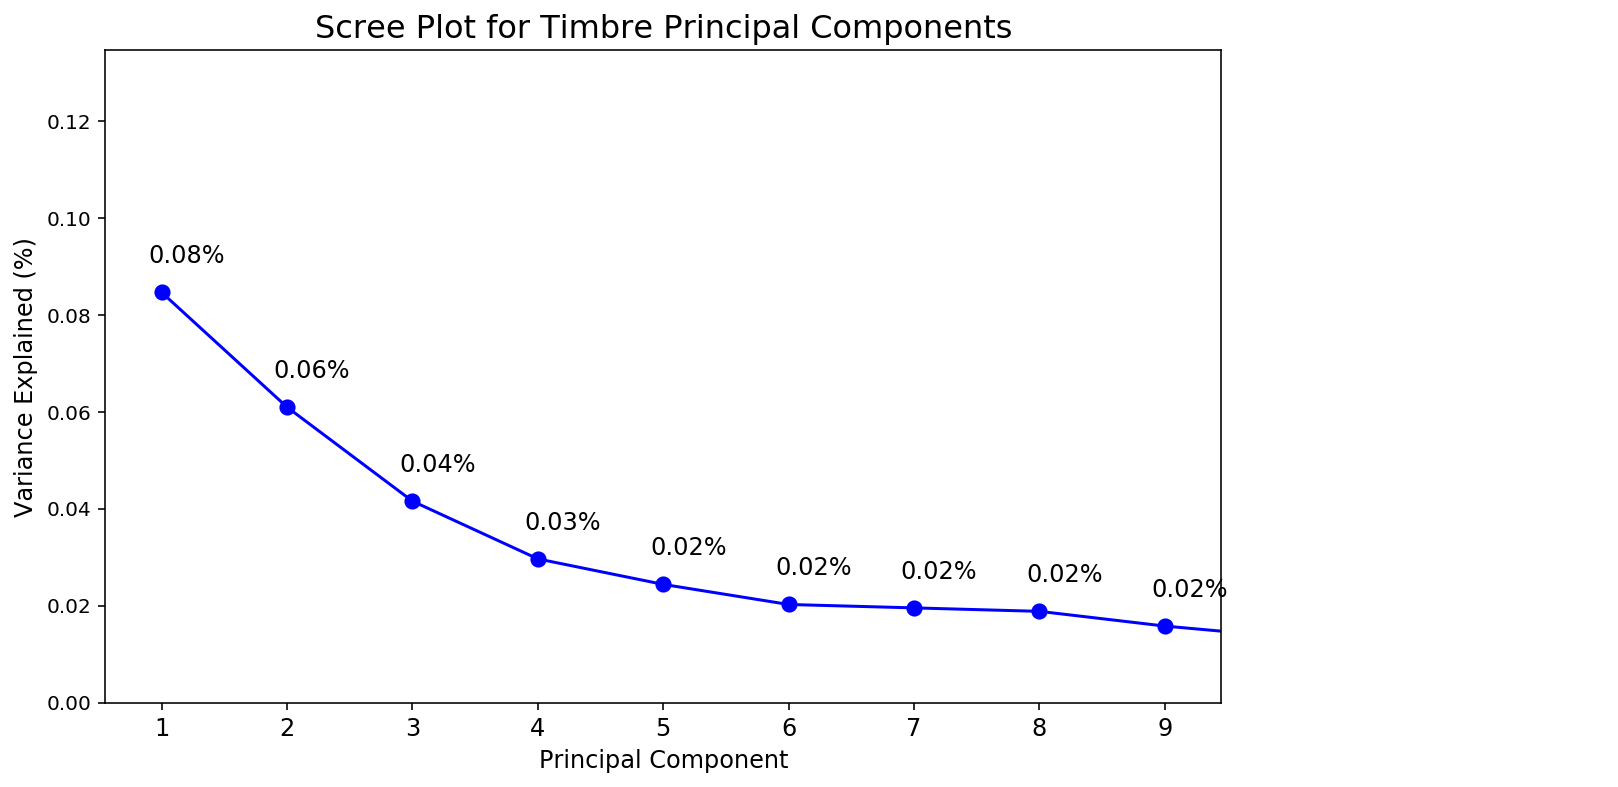

In [77]:
fig, ax = plt.subplots(figsize=(10, 6))
scree_plot(ax, pca, title="Scree Plot for Timbre Principal Components")

Looks like there's an elbow around **6 components**.

In [78]:
def plot_mnist_embedding(ax, X, y, title=None):
    """Plot an embedding of the mnist dataset onto a plane.
    
    Parameters
    ----------
    ax: matplotlib.axis object
      The axis to make the scree plot on.
      
    X: numpy.array, shape (n, 2)
      A two dimensional array containing the coordinates of the embedding.
      
    y: numpy.array
      The labels of the datapoints.  Should be digits.
      
    title: str
      A title for the plot.
    """
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    ax.axis('off')
    ax.patch.set_visible(False)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], 
                 str(y_train[i]), 
                 color=plt.cm.Set1((y[i]+1) / 10.), 
                 fontdict={'weight': 'bold', 'size': 12})

    ax.set_xticks([]), 
    ax.set_yticks([])
    ax.set_ylim([-0.1,1.1])
    ax.set_xlim([-0.1,1.1])

    if title is not None:
        ax.set_title(title, fontsize=16)

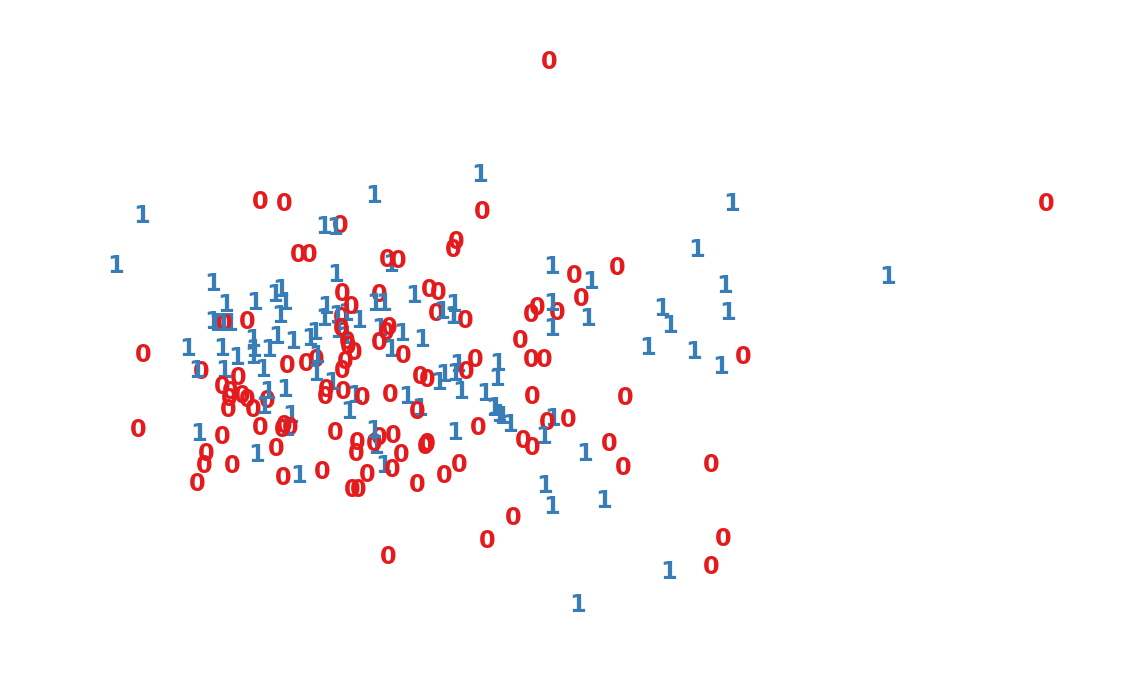

In [79]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_centered)


fig, ax = plt.subplots(figsize=(10, 6))
plot_mnist_embedding(ax, X_pca, y_train)

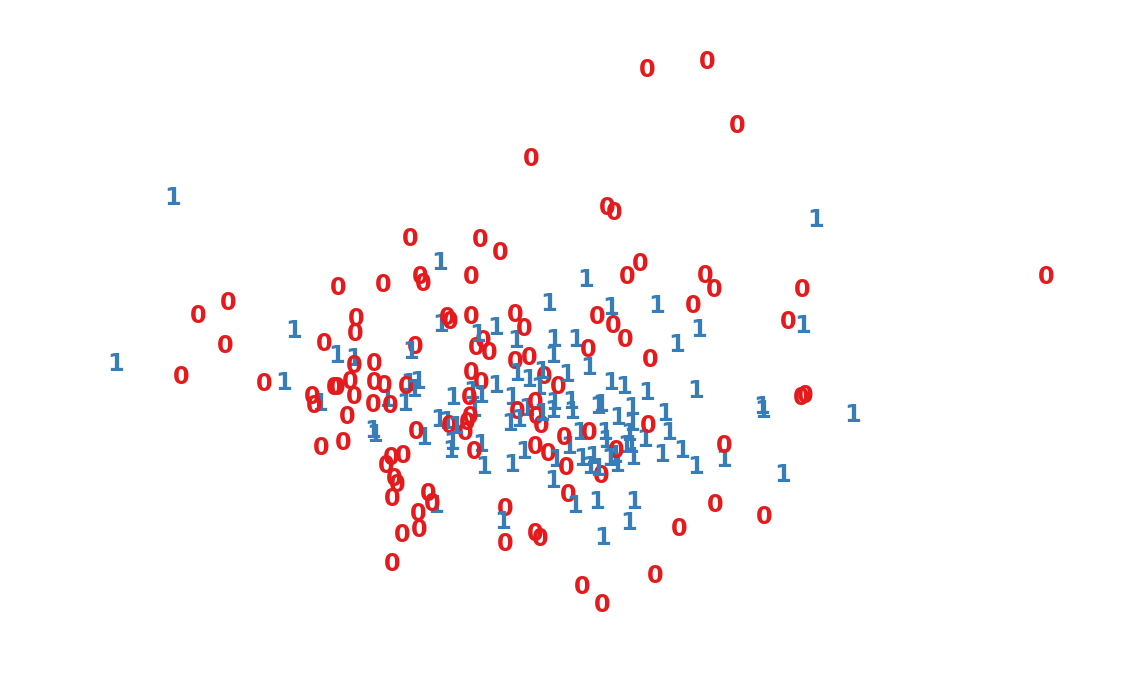

In [80]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train_centered)
X_pca = X_pca[:,1:]


fig, ax = plt.subplots(figsize=(10, 6))
plot_mnist_embedding(ax, X_pca, y_train)

Maka a KNN Classifier

In [81]:
from sklearn.neighbors import KNeighborsClassifier

In [82]:
knn = KNeighborsClassifier()

In [83]:
X_test_centered = ss.transform(X_test)

In [97]:
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_train_centered)
X_test_pca = pca.transform(X_test_centered)


knn.fit(X_pca, y_train)
y_hat = knn.predict(X_test_pca)
acc = knn.score(X_test_pca, y_test)

print('Accuracy is: {}'.format(acc))

Accuracy is: 0.6989247311827957


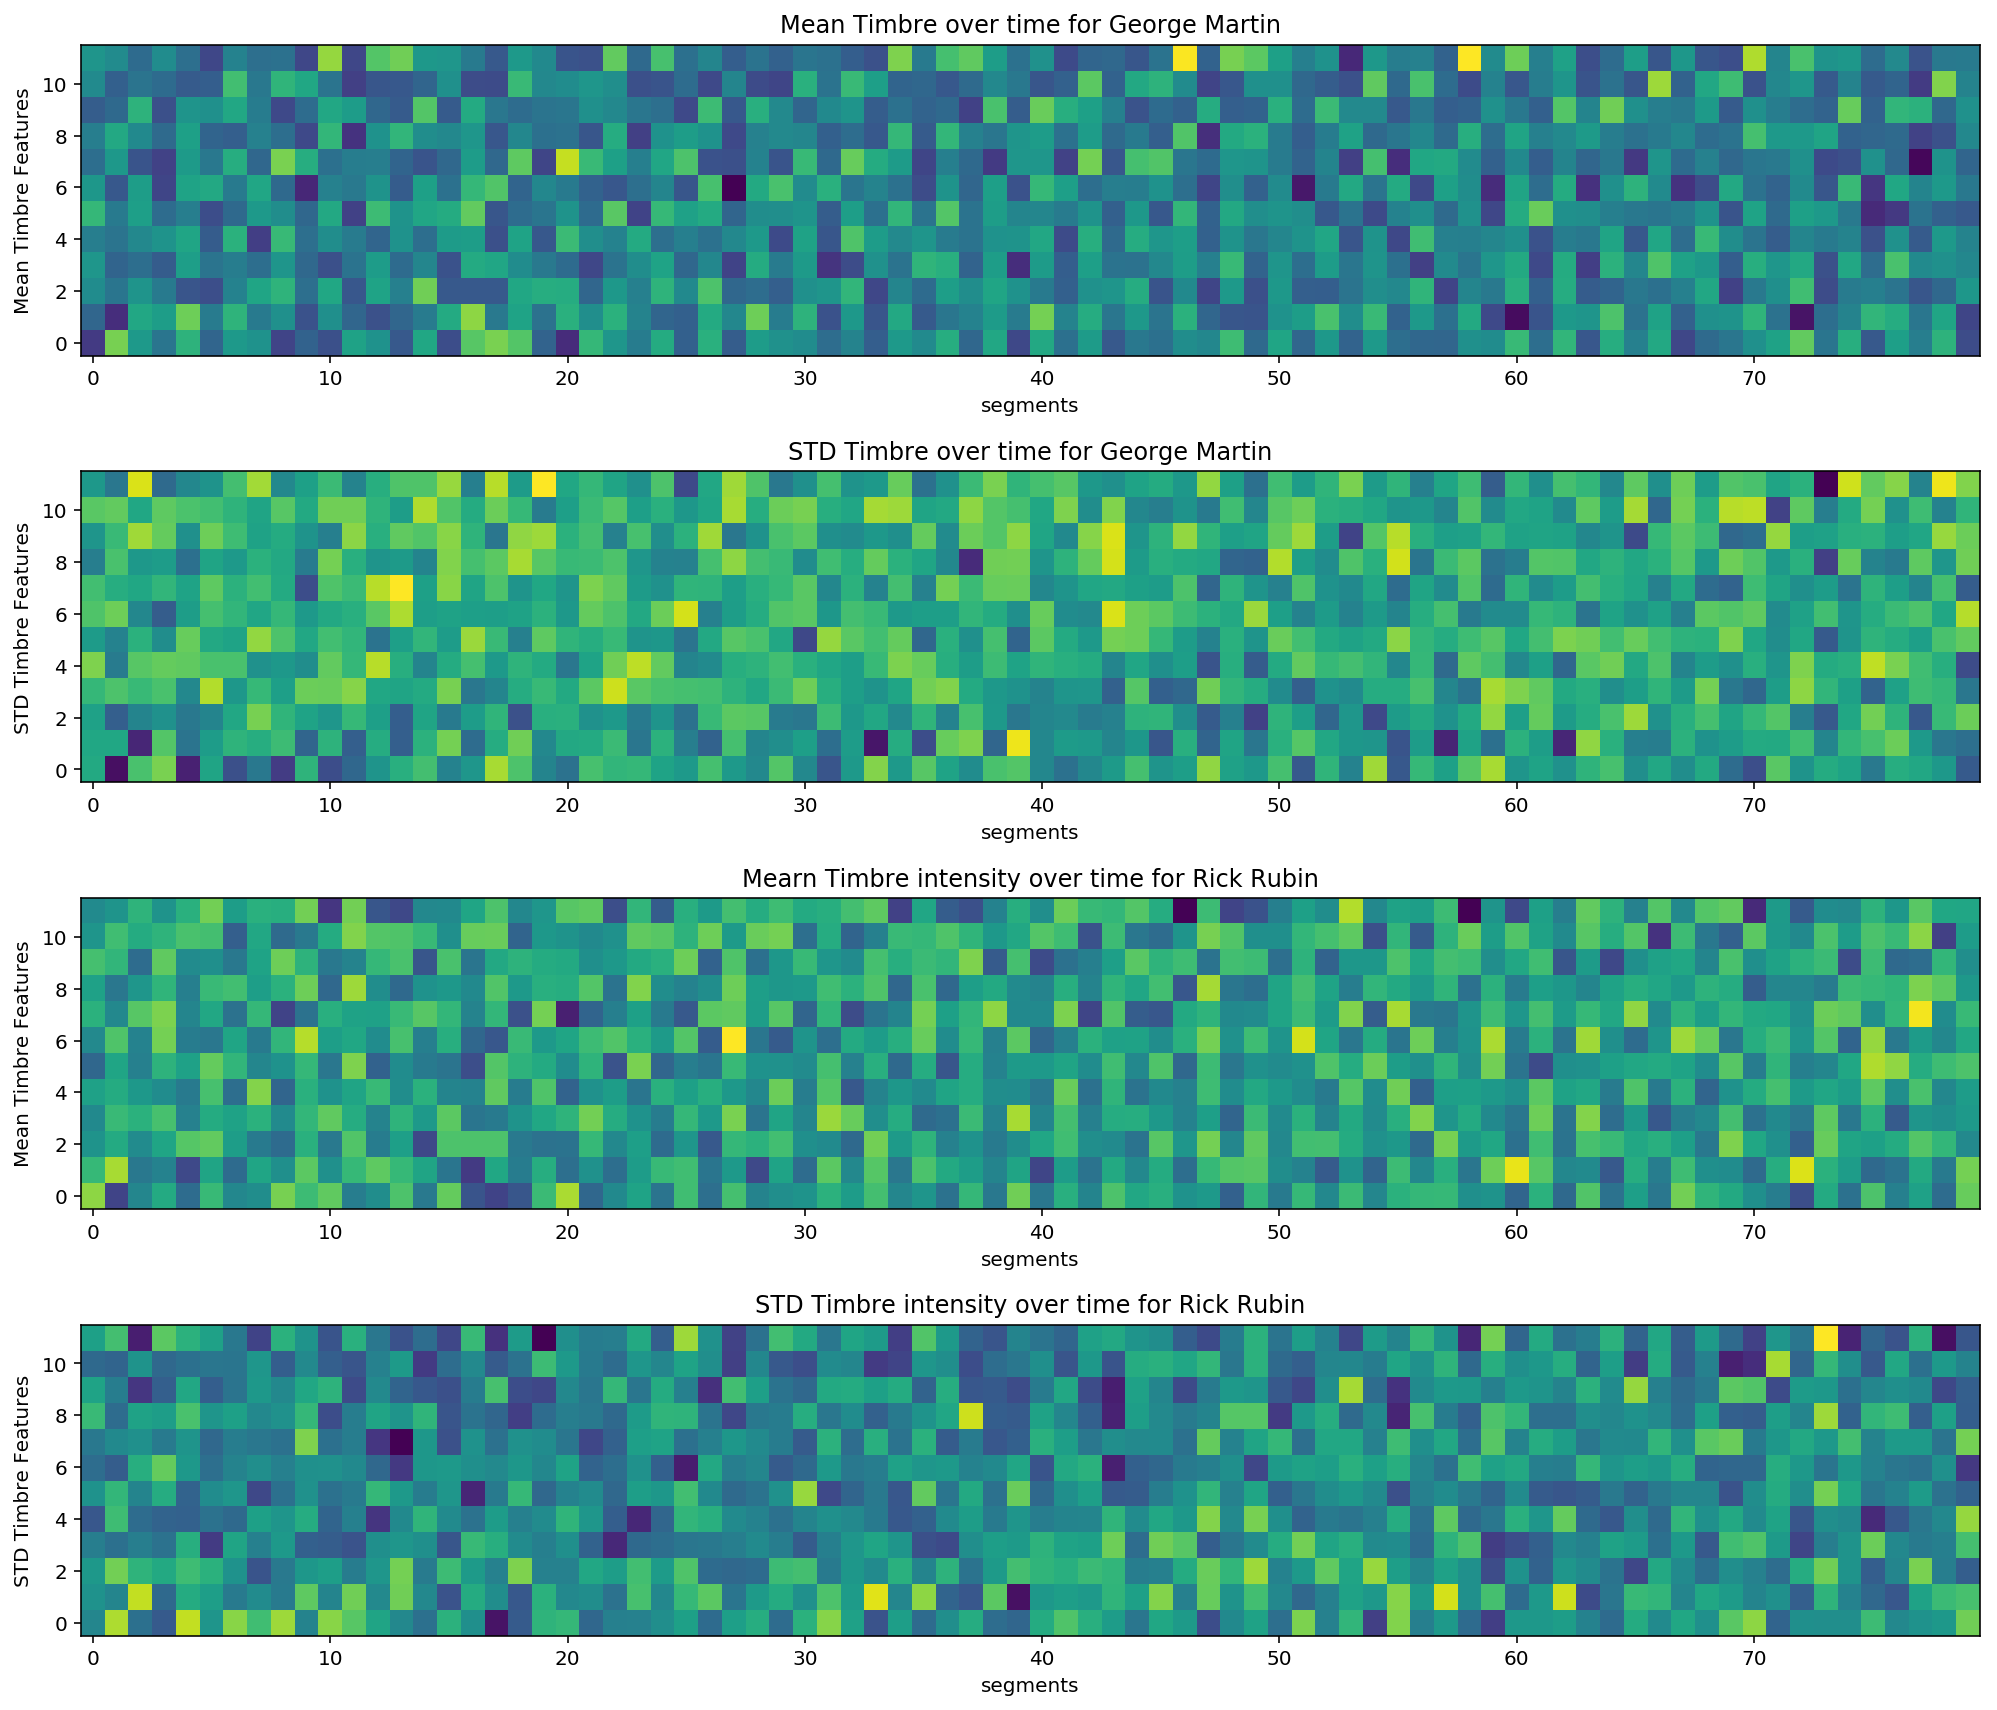

In [111]:
X_train_centered[y_train == 1].mean(axis = 0).reshape(12,-1)

fig, axs = plt.subplots(4, figsize=(14, 12))
axs[0].imshow(X_train_centered[y_train == 1].mean(axis = 0).reshape(12,-1), aspect='auto', origin = 'lower')
axs[0].set_xlabel('segments')
axs[0].set_ylabel('Mean Timbre Features')
# axs[0].colorbar()
axs[0].set_title("Mean Timbre over time for George Martin")

axs[1].imshow(X_train_centered[y_train == 1].std(axis = 0).reshape(12,-1), aspect='auto', origin = 'lower')
axs[1].set_xlabel('segments')
axs[1].set_ylabel('STD Timbre Features')
# axs[0].colorbar()
axs[1].set_title("STD Timbre over time for George Martin")

axs[2].imshow(X_train_centered[y_train == 0].mean(axis = 0).reshape(12,-1), aspect='auto', origin = 'lower')
axs[2].set_xlabel('segments')
axs[2].set_ylabel('Mean Timbre Features')
# axs[1].colorbar()
axs[2].set_title("Mearn Timbre intensity over time for Rick Rubin")

axs[3].imshow(X_train_centered[y_train == 0].std(axis = 0).reshape(12,-1), aspect='auto', origin = 'lower')
axs[3].set_xlabel('segments')
axs[3].set_ylabel('STD Timbre Features')
# axs[1].colorbar()
axs[3].set_title("STD Timbre intensity over time for Rick Rubin")

plt.tight_layout()
fig.show()